In [3]:
%matplotlib inline

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import ml_plotting as ml_p

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Import and clean diabetes dataset

In [4]:
diabetes = pd.read_csv('diabetic_data.csv')

In [5]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
diabetes.replace('?', np.NaN, inplace=True)

Data cleaning

In [7]:
for col in diabetes:
    print("Unique values for feature {0} :".format(col), diabetes[col].nunique())
    print("The number of null values:", diabetes[col].isnull().sum() )

Unique values for feature encounter_id : 101766
The number of null values: 0
Unique values for feature patient_nbr : 71518
The number of null values: 0
Unique values for feature race : 5
The number of null values: 2273
Unique values for feature gender : 3
The number of null values: 0
Unique values for feature age : 10
The number of null values: 0
Unique values for feature weight : 9
The number of null values: 98569
Unique values for feature admission_type_id : 8
The number of null values: 0
Unique values for feature discharge_disposition_id : 26
The number of null values: 0
Unique values for feature admission_source_id : 17
The number of null values: 0
Unique values for feature time_in_hospital : 14
The number of null values: 0
Unique values for feature payer_code : 17
The number of null values: 40256
Unique values for feature medical_specialty : 72
The number of null values: 49949
Unique values for feature num_lab_procedures : 118
The number of null values: 0
Unique values for feature

Remove features that are not very important
1. encounter_id - unique to each instance
2. patient_number - unique to each patient
3. weight - missing for 97% of the dataset
4. payer_code - which insurance the patient had. Missing for 52% of dataset
5. medical_specialty - speciality of admitted physician. Missing for 53 % of data
6. admission_source_id - not as important
7. admission_type_id - not as important

In [8]:
drop_cols = ['encounter_id','patient_nbr','weight','payer_code','medical_specialty',
             'admission_source_id', 'admission_type_id']
diabetes.drop(drop_cols, axis=1, inplace=True)

In [9]:
#Since the nulls in each column take up a very small portion of the data, just fill with most common value
cols = diabetes.columns.values
diabetes[cols]=diabetes[cols].fillna(diabetes.mode().iloc[0])

In [10]:
## format age feature. 0 maps to [0-10), 1 maps tp [10,20)...etc
diabetes['age'] = diabetes['age'].str[1]

In [11]:
## Female is the most common entry for gender
diabetes.loc[diabetes['gender'] == 'Unknown/Invalid', 'gender'] = 'Female'

In [12]:
diags = ['diag_1','diag_2','diag_3']
for diag in diags:
    print('feature:', diabetes[diag].value_counts().head(5))

feature: 428    6883
414    6581
786    4016
410    3614
486    3508
Name: diag_1, dtype: int64
feature: 276    7110
428    6662
250    6071
427    5036
401    3736
Name: diag_2, dtype: int64
feature: 250    12978
401     8289
276     5175
428     4577
427     3955
Name: diag_3, dtype: int64


In [13]:
diabetes.loc[(diabetes.diag_1 != '428') | (diabetes.diag_1 != '414') | (diabetes.diag_1 != '786') |
             (diabetes.diag_1 != '410') | (diabetes.diag_1 != '486'), 'diag_1'] = 'Other'

In [14]:
diabetes.loc[(diabetes.diag_2 != '276') | (diabetes.diag_2 != '428') | (diabetes.diag_2 != '250') |
             (diabetes.diag_2 != '427') | (diabetes.diag_2 != '401'), 'diag_2'] = 'Other'

In [15]:
diabetes.loc[(diabetes.diag_3 != '250') | (diabetes.diag_3 != '401') | (diabetes.diag_3 != '276') |
             (diabetes.diag_3 != '428') | (diabetes.diag_3 != '407'), 'diag_3'] = 'Other'

In [16]:
label_cols = ['race','gender', 'diag_1','diag_2','diag_3']

starting = diabetes.columns.get_loc('max_glu_serum')
ending = diabetes.columns.size

feature_cols = diabetes.columns.values[starting:ending].tolist()
for features in label_cols:
    feature_cols.append(features)


In [17]:
# One label encoding for all catagorical data.
diabetes[feature_cols] = diabetes[feature_cols].apply(LabelEncoder().fit_transform)

split x and y, scale and/or normalize the data

In [18]:
y_diabetes = diabetes['readmitted']

X = diabetes.drop('readmitted', axis=1)
X_diabetes_scaled = scale(X)

## For time, selecting 20% of this data
X_train, _, y_train, _ = train_test_split(X_diabetes_scaled, y_diabetes, test_size=0.8, random_state=42)

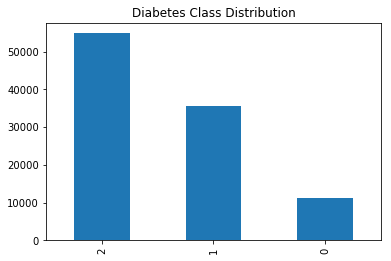

In [19]:
y_diabetes.value_counts().plot(kind='bar', title="Diabetes Class Distribution")

In [20]:
y_diabetes.value_counts(normalize= True)

2    0.539119
1    0.349282
0    0.111599
Name: readmitted, dtype: float64

# Import and clean chords data

In [21]:
chord_columns = ['choral_id', 'event_number','c','c#','d','d#','e','f','f#','g','g#','a','a#',
                'b','bass','meter','chord']
chords = pd.read_csv('jsbach_chorals_harmony_2/chords_data.txt', header=None, index_col=False, 
                    names = chord_columns)

In [22]:
## drop event_number

chords.drop('event_number', axis=1, inplace=True)

there are 101 chords represented in the dataset. In order to make the problem more simple I will condense them into the following chord classes

1. Major -
    Contains: Major, Major 4th, Major 6th, and Major 7th
2. Minor -
    Contains: Minor, Minor 6th, and Minor 7th
3. Diminished -
    Contains: Diminished, Diminished 6th, and Diminished 7th

In [23]:
chords_y = chords['chord']
chords_y.loc[(chords_y.str.endswith('M')) | (chords_y.str.endswith('M4')) |
            (chords_y.str.endswith('M6')) | (chords_y.str.endswith('M7'))] = 'Major'

chords_y.loc[(chords_y.str.endswith('m')) |chords_y.str.endswith('m4') |
            (chords_y.str.endswith('m7')) | (chords_y.str.endswith('m6'))] = 'Minor'

chords_y.loc[(chords_y.str.endswith('d')) |(chords_y.str.endswith('d6')) |
            (chords_y.str.endswith('d7'))] = 'Dim'

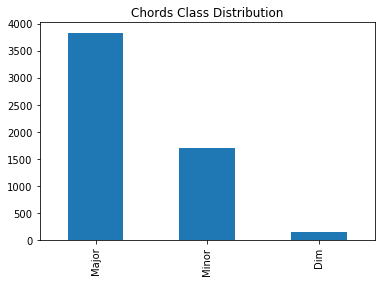

In [24]:
chords_y.value_counts().plot(kind='bar', title="Chords Class Distribution") 

In [25]:
chords_y.value_counts(normalize = True)

Major    0.676258
Minor    0.298676
Dim      0.025066
Name: chord, dtype: float64

In [26]:
chords_y = LabelEncoder().fit_transform(chords_y)

In [27]:
## working with inputs
chords.drop('chord', axis = 1, inplace=True)
transform_cols = (chords.columns.values)[0:-1]
chords[transform_cols] = chords[transform_cols].apply(LabelEncoder().fit_transform)

In [28]:
X_chords_scaled = scale(chords)

# Useful Functions

# Decision Trees

Diabetes

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

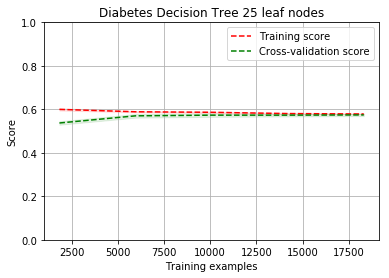

In [29]:
diabetes_tree = DecisionTreeClassifier(criterion = "entropy", max_leaf_nodes = 25)
ml_p.plot_learning_curve(diabetes_tree, 'Diabetes Decision Tree 25 leaf nodes', X_train, y_train, cv=10)

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

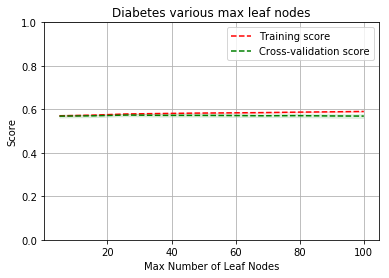

In [30]:
ml_p.plot_various_max_leaf("Diabetes various max leaf nodes", 
                      X_train,y_train, cv=10,min_nodes = 5, max_nodes= 100, step_size=10)

Chords

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

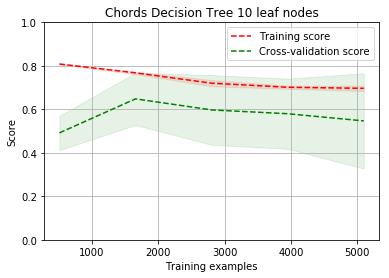

In [31]:
chords_tree = DecisionTreeClassifier(criterion = "entropy", max_leaf_nodes=10)
ml_p.plot_learning_curve(chords_tree, 'Chords Decision Tree 10 leaf nodes',
                    X_chords_scaled, chords_y, cv=10)
    

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

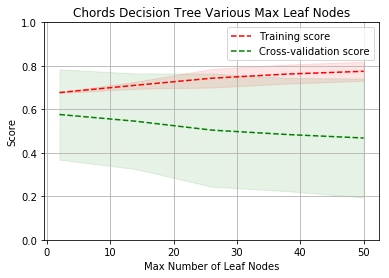

In [32]:
ml_p.plot_various_max_leaf("Chords Decision Tree Various Max Leaf Nodes",
                      X_chords_scaled,chords_y, cv=10,min_nodes = 2, max_nodes= 50, step_size=5)

# Neural Nets

Chords

In [31]:
mlp0 = MLPClassifier(hidden_layer_sizes = (9,) ,solver = 'sgd', activation ='relu', momentum = 0)
mlp1 = MLPClassifier(hidden_layer_sizes = (9,) ,solver = 'sgd', activation ='relu', momentum = 0.6 )
mlp2 = MLPClassifier(hidden_layer_sizes = (9,) ,solver = 'sgd', activation ='relu', momentum = 0.9 )
mlp3 = MLPClassifier(hidden_layer_sizes = (9,) ,solver = 'sgd', activation ='logistic', momentum =  0.0)
mlp4 = MLPClassifier(hidden_layer_sizes = (9,) ,solver = 'sgd', activation ='logistic', momentum = 0.6)
mlp5 = MLPClassifier(hidden_layer_sizes = (9,) ,solver = 'sgd', activation ='logistic', momentum = 0.9)


In [32]:
arr = [mlp0, mlp1, mlp2, mlp3, mlp4, mlp5]

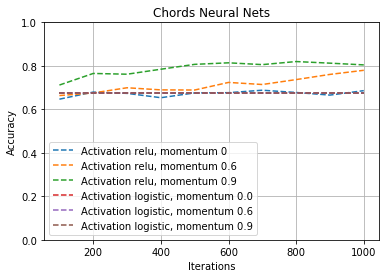

In [33]:
ml_p.plot_nnet_compare_iters(arr, 'Chords Neural Nets', X_chords_scaled, chords_y, max_iters=1000, step_size=10)

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

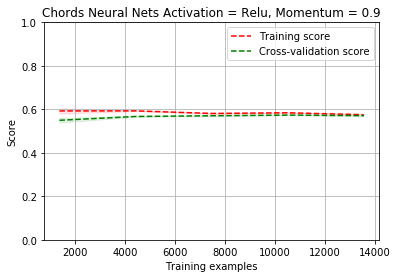

In [34]:
ml_p.plot_learning_curve(mlp2,'Chords Neural Nets Activation = Relu, Momentum = 0.9', X_train, y_train, cv= 3)

Diabetes

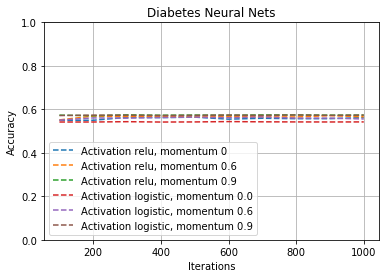

In [35]:
ml_p.plot_nnet_compare_iters(arr, 'Diabetes Neural Nets', X_train, y_train, max_iters = 1000, step_size = 10)

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

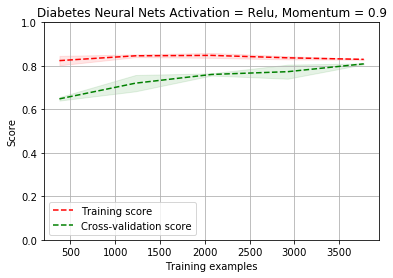

In [36]:
ml_p.plot_learning_curve(mlp2,'Diabetes Neural Nets Activation = Relu, Momentum = 0.9', X_chords_scaled, chords_y, cv= 3)

# K-NN

Chords

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

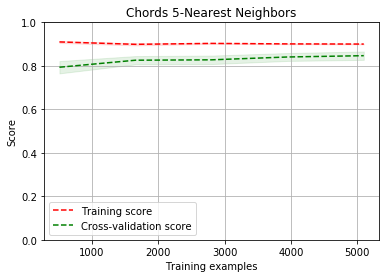

In [37]:
k_chords = KNeighborsClassifier(n_neighbors = 5)
ml_p.plot_learning_curve(k_chords, 'Chords 5-Nearest Neighbors', X_chords_scaled, chords_y, cv=10)

neighbord: 0
neighbord: 1
neighbord: 2
neighbord: 3
neighbord: 4
neighbord: 5
neighbord: 6
neighbord: 7
neighbord: 8
neighbord: 9


<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

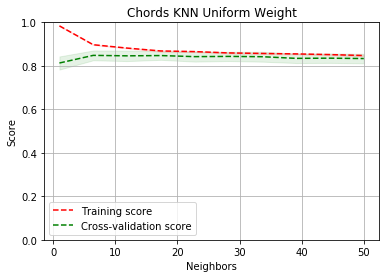

In [38]:
ml_p.plot_various_neigbors('Chords KNN Uniform Weight', X_chords_scaled, chords_y,
                      weights = 'uniform', cv=10, max_neighbors = 50)

neighbord: 0
neighbord: 1
neighbord: 2
neighbord: 3
neighbord: 4
neighbord: 5
neighbord: 6
neighbord: 7
neighbord: 8
neighbord: 9


<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

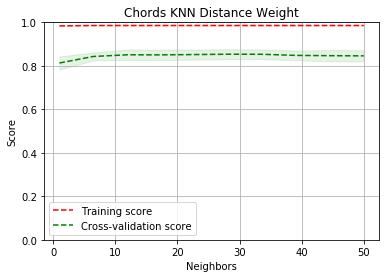

In [39]:
ml_p.plot_various_neigbors('Chords KNN Distance Weight', X_chords_scaled, chords_y,
                      weights = 'distance', cv=10, max_neighbors = 50)

run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
done with iterations


<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

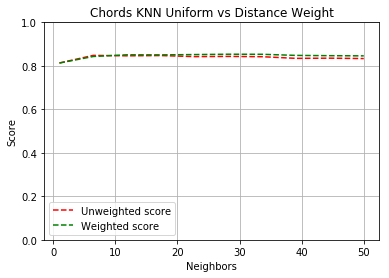

In [40]:
ml_p.plot_compare_knn_weights('Chords KNN Uniform vs Distance Weight', X_chords_scaled, chords_y, cv=10, max_neighbors = 50)

Diabetes

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

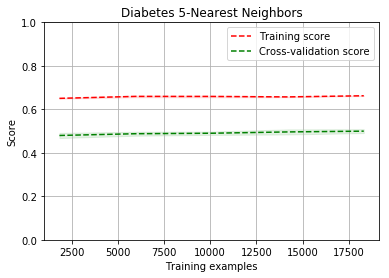

In [41]:
k_diabetes = KNeighborsClassifier(n_neighbors = 5)
ml_p.plot_learning_curve(k_diabetes, 'Diabetes 5-Nearest Neighbors', 
                    X_train, y_train, cv = 10)

neighbord: 0
neighbord: 1
neighbord: 2
neighbord: 3
neighbord: 4


<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

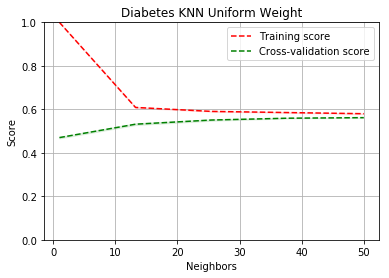

In [42]:
ml_p.plot_various_neigbors('Diabetes KNN Uniform Weight', X_train, y_train,
                      weights = 'uniform', cv=3, max_neighbors = 50, step_size=5)

neighbord: 0
neighbord: 1
neighbord: 2
neighbord: 3
neighbord: 4


<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

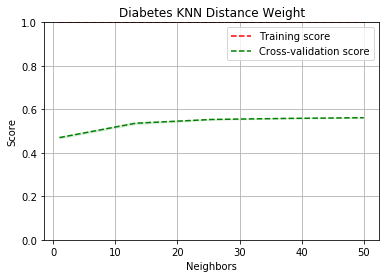

In [43]:
ml_p.plot_various_neigbors('Diabetes KNN Distance Weight', X_train, y_train,
                      weights = 'distance', cv=3, max_neighbors = 50, step_size=5)

run: 0
run: 1
run: 2
run: 3
run: 4
done with iterations


<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

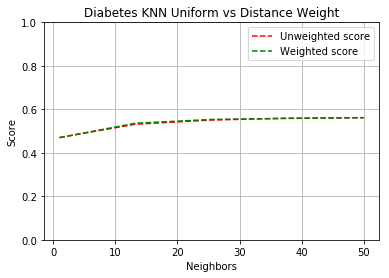

In [44]:
ml_p.plot_compare_knn_weights('Diabetes KNN Uniform vs Distance Weight', X_train, y_train, step_size=5, cv=3, max_neighbors = 50)

# SVM

Chords

estimator :  0
estimator :  1
estimator :  2
estimator :  3
estimator :  4


<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

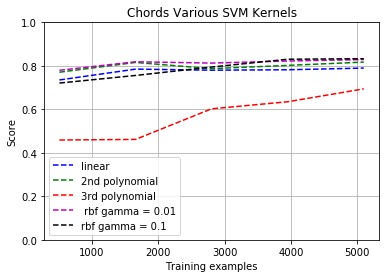

In [45]:
chords_svm = SVC(class_weight='balanced')
ml_p.plot_compare_svm('Chords Various SVM Kernels',X_chords_scaled, chords_y, cv=10)

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

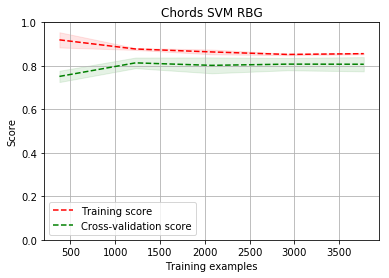

In [46]:
ml_p.plot_learning_curve(chords_svm, 'Chords SVM RBG', X_chords_scaled, chords_y)

Diabetes

estimator :  0
estimator :  1
estimator :  2
estimator :  3
estimator :  4


<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

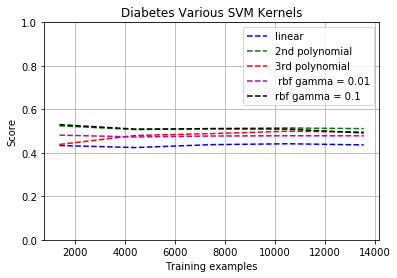

In [47]:
ml_p.plot_compare_svm('Diabetes Various SVM Kernels', X_train, y_train, cv=3)

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

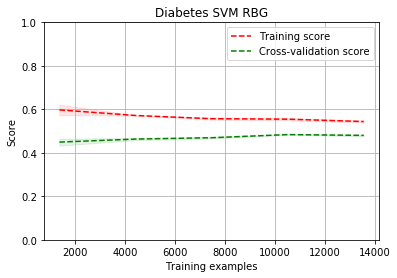

In [48]:
ml_p.plot_learning_curve(chords_svm, 'Diabetes SVM RBG', X_train, y_train)

# Boosting

Chords

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

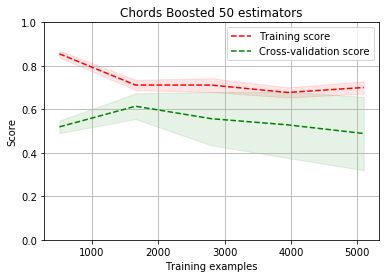

In [33]:
chords_boost = AdaBoostClassifier(chords_tree) ## Reminder that K = 5
ml_p.plot_learning_curve(chords_boost,'Chords Boosted 50 estimators', X_chords_scaled, 
                         chords_y, cv = 10)

estimator: 0
estimator: 1
estimator: 2
estimator: 3
estimator: 4
estimator: 5
estimator: 6
estimator: 7
estimator: 8
estimator: 9


<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

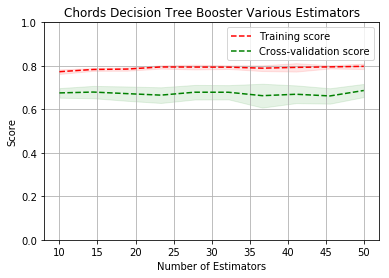

In [50]:
ml_p.plot_various_estimators(chords_boost, 'Chords Decision Tree Booster Various Estimators', 
                        X_chords_scaled, chords_y, cv=3, min_estimators = 10, max_estimators = 50)

Diabetes

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

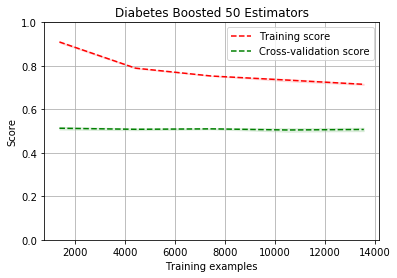

In [51]:
diabetes_boost = AdaBoostClassifier(diabetes_tree) # k = 50
ml_p.plot_learning_curve(diabetes_boost, 'Diabetes Boosted 50 Estimators',X_train, y_train, cv=3)

estimator: 0
estimator: 1
estimator: 2
estimator: 3
estimator: 4


<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

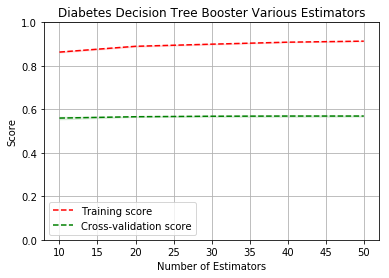

In [52]:
ml_p.plot_various_estimators(diabetes_boost, 'Diabetes Decision Tree Booster Various Estimators', 
                        X_train, y_train, cv=3, min_estimators = 10, max_estimators = 50, step_size = 5)